In [ ]:
# pip install numpy xarray netCDF4 matplotlib plotly

In [ ]:
# pip install "dask[complete]" -q

In [ ]:
# pip install geopy ipywidgets folium -q

In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import plotly.graph_objects as go
import modules.n1_utilities as uti
import datetime
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
country_to_subareas = uti.read_json_to_dict('countries.json', True)
months = uti.read_json_to_dict('months.json')
timescales = uti.read_json_to_dict('timescales.json')
area_subset_data = None
map_display = None

selected = {
    "country": None,
    "subarea": None,
    "month": None,
    "year": None,
    "timescale": None
}

placeholders = {
    "country": "country...",
    "subarea": "subarea...",
    "month": "month...",
    "year": "year...",
    "timescale": "timescale..."
}
uti.save_selection(placeholders)

In [5]:
# Dropdown for countries
country_selector = widgets.Dropdown(
    options=[placeholders['country']] + list(country_to_subareas.keys()),
    description='Select a country:',
    style={'description_width': 'initial'}
)

# Dropdown for subareas, initially empty
subarea_selector = widgets.Dropdown(
    options=[placeholders['subarea']],
    description='And a subarea:',
    style={'description_width': 'initial'}
)

# Dropdown for months
month_selector = widgets.Dropdown(
    options=[placeholders['month']] + list(months.keys()),
    description='Select a month:',
    style={'description_width': 'initial'}
)

# Dropdown for years
current_year = datetime.datetime.now().year
year_selector = widgets.Dropdown(
    options=[placeholders['year']] + [str(year) for year in range(1940, current_year + 1)],
    description='Select a year:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Dropdown for timescales
timescale_selector = widgets.Dropdown(
    options=[placeholders['timescale']] + list(timescales.keys()),
    description='Select a timescale:',
    style={'description_width': 'initial'}
)

In [8]:
def update_subarea_selector(change):
    """
    Update the options for the subarea dropdown based on the selected country.

    This function is triggered by a change in the country selector. It updates the options available in the subarea selector 
    dropdown. If the selected country has associated subareas, they will be populated in the subarea dropdown. If the selected
    value is the placeholder or if no subareas are available, the dropdown will only show the placeholder for subareas.

    Parameters:
    change (dict): The change notification received from the widget, containing 'name' and 'new' keys, where
                   'name' indicates the attribute that changed ('value' in this case), and 'new' is the new
                   value of that attribute.

    Effects:
    Updates `subarea_selector.options` with either the subareas of the selected country or the default placeholder.
    """
    if change['name'] == 'value' and change['new'] != placeholders['country']:
        subareas = country_to_subareas.get(change['new'], [])
        subarea_selector.options = [placeholders['subarea']] + subareas
    else:
        subarea_selector.options = [placeholders['subarea']]

        
        
def handle_time_interactivity(change):
    """
    Handle interactivity for time-related selections in a GUI environment. This function responds to changes in year or month
    selectors by adjusting the other's value to a default state and updates the subset of area data displayed accordingly.

    This function uses a global variable `area_subset_data` which stores the filtered data based on the user's selections.
    It updates this data whenever a change is made to either the month or year selectors.

    Parameters:
    change (dict): A dictionary containing information about the change event. This dictionary includes keys like 'owner',
                   which refers to the widget (year_selector or month_selector) that triggered the event, and 'new', which
                   indicates the new value selected by the user.

    The function expects several external widgets to be defined, including `year_selector`, `month_selector`,
    `country_selector`, `subarea_selector`, `timescale_selector`, as well as global placeholders and utility functions.
    """
    global area_subset_data
    if change['owner'] == year_selector:
        if change['new'] != placeholders['year']:  
            month_selector.value = placeholders['month']  
    elif change['owner'] == month_selector:
        if change['new'] != placeholders['month']:  
            year_selector.value = placeholders['year']  
    # Update data based on new selection
    area_subset_data = uti.update_display(country_selector, subarea_selector, month_selector, year_selector, timescale_selector, months, timescales, placeholders)
        

def on_value_change(change):
    """
    Responds to changes in selection widgets to update map displays and data processing. This function modifies the global
    `selected` dictionary, updates the `area_subset_data`, and refreshes the `map_display` based on user selections from
    various selectors. It provides visual feedback via an output area in the UI.

    The function is intended to be connected to widgets that trigger changes. It uses a dictionary `placeholders` 
    to manage default values and checks against them to filter out default or placeholder selections.

    Parameters:
    change (dict): Contains details about the widget event that triggered the update, with keys 'type', 'name', and 'new', where 
                   'new' is the newly selected country value.
    """
    global area_subset_data, selected, map_display
    with output_area:
        clear_output(wait=True)
        selected.update({
            'country': country_selector.value if country_selector.value != placeholders['country'] else None,
            'subarea': subarea_selector.value if subarea_selector.value != placeholders['subarea'] else None,
            'month': month_selector.value if month_selector.value != placeholders['month'] else None,
            'year': year_selector.value if year_selector.value != placeholders['year'] else None,
            'timescale': timescale_selector.value if timescale_selector.value != placeholders['timescale'] else None
        })

        uti.save_selection(selected)
        map_display = None
        if selected['country']:
            bounds = uti.get_bounds(selected['country'])
            if selected['subarea']:
                bounds = uti.get_bounds(selected['subarea'])
            map_display = uti.display_map(bounds)

        if any(value is not None for value in selected.values()):
            area_subset_data = uti.update_display(country_selector, subarea_selector, month_selector, year_selector, timescale_selector, months, timescales, placeholders)
            print(f"Data updated for: {selected}")
        else:
            print("Selection incomplete. Please select all required options.")
        if map_display:
            map_iframe = uti.display_map_in_iframe(map_display)
            display(map_iframe)

            

def setup_observers():
    """
    Sets up observers for UI widgets to handle interactions and updates dynamically in a graphical user interface.
    This function ensures that observers are only set once using a function attribute to track whether observers have
    already been established, enhancing efficiency and preventing multiple bindings to the same event.

    Observers are attached to widgets for month, year, country, subarea, and timescale selections. These observers trigger
    specific functions when the 'value' property of the widgets changes, facilitating responsive updates to the user interface
    based on user interactions.

    The function `handle_time_interactivity`, `on_value_change`, and `update_subarea_selector` are called depending
    on the specific widget interaction, addressing different aspects of the UI and data updates required by the application.

    Notes:
    - This function uses a custom attribute `observers_set` on itself to ensure observers are set only once.
    """
    if not hasattr(setup_observers, 'observers_set'):
        # Observe changes for month selector
        month_selector.observe(handle_time_interactivity, names='value')
        month_selector.observe(on_value_change, names='value')
        
        # Observe changes for year selector
        year_selector.observe(handle_time_interactivity, names='value')
        year_selector.observe(on_value_change, names='value')
        
        country_selector.observe(update_subarea_selector, names='value')
        country_selector.observe(on_value_change, names='value')
        subarea_selector.observe(on_value_change, names='value')
        timescale_selector.observe(on_value_change, names='value')

        # Set a flag to indicate observers are set
        setup_observers.observers_set = True
        
setup_observers()
# Output area for display updates
output_area = widgets.Output()

In [ ]:
# Update existing selectors
previous_selection = uti.read_json_to_dict('previous_selection.json')

# Set up widgets with previous settings
country_selector.value = previous_selection.get('country', placeholders['country'])
subarea_selector.value = previous_selection.get('subarea', placeholders['subarea'])
month_selector.value = previous_selection.get('month', placeholders['month'])
timescale_selector.value = previous_selection.get('timescale', placeholders['timescale'])

# Display widgets
display(country_selector, subarea_selector, timescale_selector, month_selector, output_area)

In [ ]:
index = f"SPEI{timescales[selected['timescale']]}"
# print(area_subset_data[index].values)

In [ ]:
print("Country: ", selected['country'])
print("Subarea: ", selected['subarea'])
print("Month: ", selected['month'])
print("Timescale: ", selected['timescale'])
print("Latitude values in the subset:", area_subset_data[index].lat.values.shape[0])
print("Longitude values in the subset:", area_subset_data[index].lon.values.shape[0])
print("Data: ", area_subset_data)

In [ ]:
area_subset_data[index] = uti.replace_invalid_values(area_subset_data[index])

In [ ]:
mean_values = uti.compute_means(area_subset_data[index])

In [ ]:
uti.create_scatterplot(mean_values, timescales, selected)

In [ ]:
boxplot_stats = uti.compute_boxplot_stats(area_subset_data[index])

In [ ]:
uti.create_boxplot(boxplot_stats, timescales, selected)

In [ ]:
# Update existing selectors
previous_selection = uti.read_json_to_dict('previous_selection.json')

# Set up widgets with previous settings
country_selector.value = previous_selection.get('country', placeholders['country'])
subarea_selector.value = previous_selection.get('subarea', placeholders['subarea'])
year_selector.value = previous_selection.get('year', placeholders['year'])
timescale_selector.value = previous_selection.get('timescale', placeholders['timescale'])

# Add the new year selector to the display
display(country_selector, subarea_selector, timescale_selector, year_selector, output_area)

In [62]:
index = f"SPEI{timescales[selected['timescale']]}"

In [80]:
print("Country: ", selected['country'])
print("Subarea: ", selected['subarea'])
print("Month: ", selected['month'])
print("Timescale: ", selected['timescale'])
print("Latitude values in the subset:", area_subset_data[index].lat.values.shape[0])
print("Longitude values in the subset:", area_subset_data[index].lon.values.shape[0])
# print("Data: ", area_subset_data)
print(area_subset_data[index].isel(time=0, lat=slice(0, 5), lon=slice(0, 5)).values)

Country:  Italy
Subarea:  Emilia-Romagna
Month:  None
Timescale:  1 month
Latitude values in the subset: 131
Longitude values in the subset: 139
[[1.83803506 1.92490055 2.05360618 1.92028756 1.91839116]
 [1.27425792 1.43355603 1.50096742 1.4800947  1.46066785]
 [0.56577193 0.70935765 0.69132173 0.70450052 0.76826711]
 [0.18781828 0.15544314 0.18814953 0.17482951 0.26855511]
 [0.02107444 0.01288017 0.15828877 0.1302039  0.19633518]]


In [81]:
area_subset_data[index] = uti.replace_invalid_values(area_subset_data[index])

In [85]:
mean_values = uti.compute_means(area_subset_data[index])

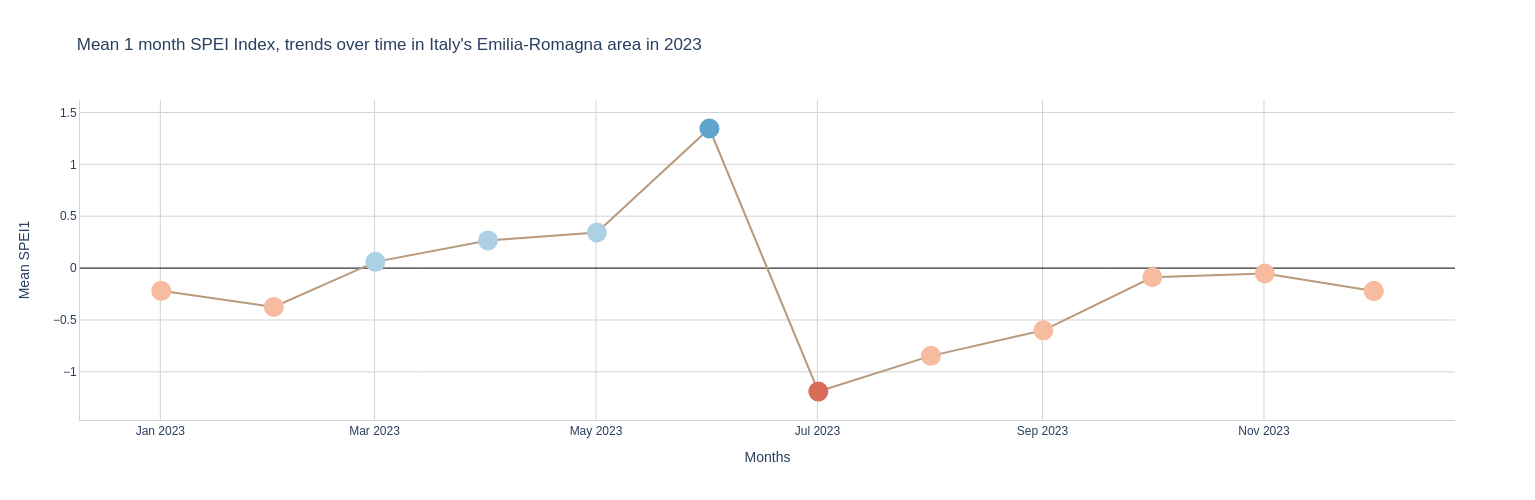

In [84]:
uti.create_linechart(mean_values, timescales, selected)

source: https://en.wikipedia.org/wiki/List_of_administrative_divisions_by_country